In [ ]:
** Final model - GBM implementation **

Index(['ID', 'County', 'InstallType', 'UrbanRural', 'Class', 'Percent_100',
       'Substation_100', 'HIFLD_100', 'Percent_200', 'Substation_200',
       'HIFLD_200', 'Percent_CAISO', 'Substation_CAISO', 'HIFLD_CAISO',
       'SolarTech', 'Area', 'Length', 'DistSub_100_binned',
       'DistSub_200_binned', 'DistSub_CAISO_binned'],
      dtype='object')
Accuracy: 0.925

Confusion Matrix:
 [[405   6  16]
 [ 12 268   7]
 [ 19  21 326]]

GBM Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       427
           1       0.91      0.93      0.92       287
           2       0.93      0.89      0.91       366

    accuracy                           0.93      1080
   macro avg       0.92      0.92      0.92      1080
weighted avg       0.93      0.93      0.92      1080

ROC-AUC Score: 0.985874082222517
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n

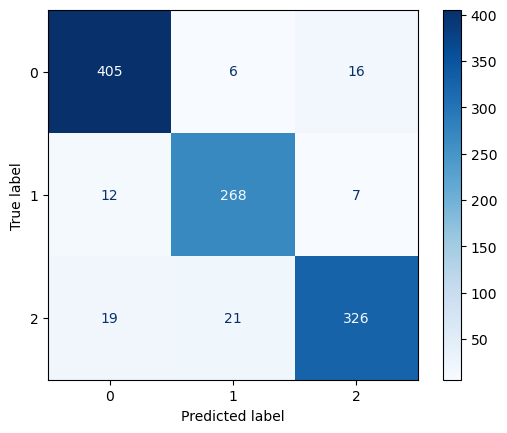

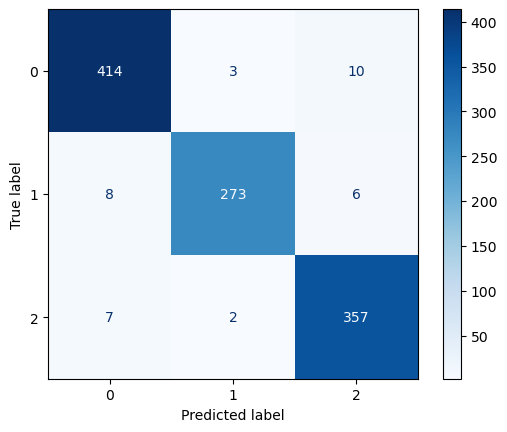

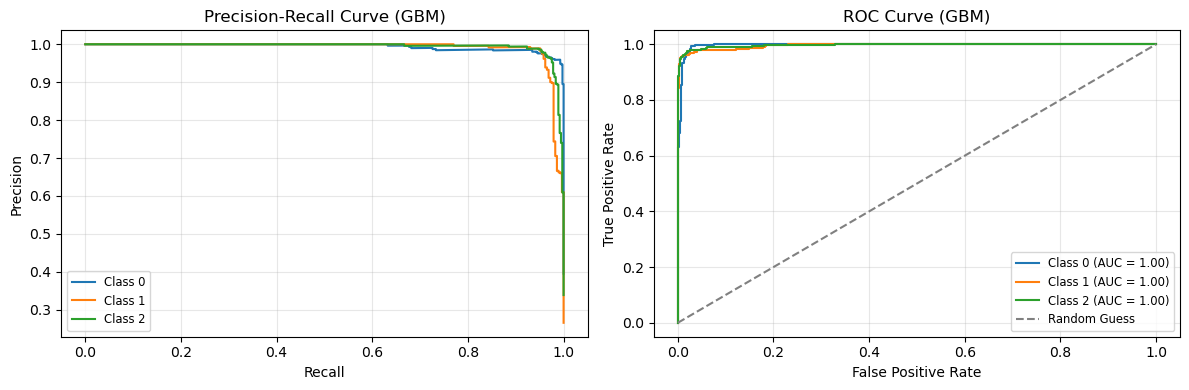

In [1]:
#importing all the necessary libraries
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix,ConfusionMatrixDisplay,roc_auc_score,roc_curve,auc,precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import  GridSearchCV,RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import jaccard_score

#loading the transformed Data Set
solar_data = pd.read_csv(r"solar_data_transformed18.csv")
print(solar_data.columns)

X = solar_data.drop(columns=['ID','InstallType'])  # Features
y = solar_data['InstallType']  # Target

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the GBM model
gbm_model = GradientBoostingClassifier(random_state=42)
gbm_model.fit(X_train, y_train)

# Make predictions
y_pred = gbm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nGBM Classification Report:\n", classification_rep)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')

y_prob = gbm_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print("ROC-AUC Score:", roc_auc)

# Define parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

# Grid Search
gbm = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predict on the test set
y_pred_gbm_tuned = best_model.predict(X_test)

# Calculate accuracy
gbm_tuned_accuracy = accuracy_score(y_test, y_pred_gbm_tuned)

# Classification report for detailed metrics
gbm_tuned_report = classification_report(y_test, y_pred_gbm_tuned)

print("Tuned GBM Accuracy:", gbm_tuned_accuracy)
print("Tuned GBM Classification Report:\n", gbm_tuned_report)

# Confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_gbm_tuned))

conf_matrix=confusion_matrix(y_test, y_pred_gbm_tuned)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')

y_prob = best_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print("ROC-AUC Score:", roc_auc)

# Ensure binary format for true labels
n_classes = len(best_model.classes_)
y_test_bin = label_binarize(y_test, classes=best_model.classes_)

# Get predicted probabilities
y_prob = best_model.predict_proba(X_test)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Plot Precision-Recall Curves
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    axes[0].plot(recall, precision, label=f"Class {best_model.classes_[i]}")

axes[0].set_title("Precision-Recall Curve (GBM)", fontsize=12)
axes[0].set_xlabel("Recall", fontsize=10)
axes[0].set_ylabel("Precision", fontsize=10)
axes[0].legend(loc="lower left", fontsize='small')
axes[0].grid(alpha=0.3)

# Plot ROC Curves
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, label=f"Class {best_model.classes_[i]} (AUC = {roc_auc:.2f})")

axes[1].plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Guess")
axes[1].set_title("ROC Curve (GBM)", fontsize=12)
axes[1].set_xlabel("False Positive Rate", fontsize=10)
axes[1].set_ylabel("True Positive Rate", fontsize=10)
axes[1].legend(loc="lower right", fontsize='small')
axes[1].grid(alpha=0.3)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()




In [3]:
# 2. Save the model to a .pkl file
with open('GBMmodel.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print("Model saved as model.pkl")

# 3. Load the model from the .pkl file
with open('GBMmodel.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Verify the loaded model works
print("Model loaded successfully")
print(f"Accuracy: {loaded_model.score(X_test, y_test):.2f}")

Model saved as model.pkl
Model loaded successfully
Accuracy: 0.97


#### GBM Insights

In [ ]:
The tuned GBM outperforms the original model slightly, which means that hyperparameter tuning really improved this model's performance.
The accuracy increased from 92.5% to 96.66%, which shows that fine-tuning reduced minor classification errors.
Precision, Recall, and F1-scores are all around above 95, which means very consistent performance across all classes.
Tuning these metrics does not break, with a balance held across the dataset.

In [4]:
#Use roc_auc_score with 'ovr' or 'ovo' for multiclass
print("ROC-AUC Score (OVR):", roc_auc_score(y_test, y_prob, multi_class='ovr'))
print("ROC-AUC Score (OVO):", roc_auc_score(y_test, y_prob, multi_class='ovo'))
#print("Matthews Correlation Coefficient:", matthews_corrcoef(y_test, y_pred_dt))
from sklearn.metrics import cohen_kappa_score
kappa_score = cohen_kappa_score(y_test, y_pred)
print("Cohen's Kappa Score:", kappa_score)
print("Jaccard Score (Macro):", jaccard_score(y_test, y_pred, average='macro'))
print("Matthews Correlation Coefficient:", matthews_corrcoef(y_test, y_pred))

ROC-AUC Score (OVR): 0.9960300940274504
ROC-AUC Score (OVO): 0.9958350699347042
Cohen's Kappa Score: 0.8860683824132717
Jaccard Score (Macro): 0.8586096443964939
Matthews Correlation Coefficient: 0.8863188829335619
